In [1]:
# Load Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

import model_prep

datapath = "../data"

2023-06-12 16:07:17.365929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h1 style="color:#27469c">ESB Cooling Tower 1 - Summer Data</h1>

In [2]:
step_back = 6
step_forward = 1

<h2 style="color:#27469c">1. Create timestepped data on pandas and normalize</h2>

In [3]:
df = pd.read_csv(f'{datapath}/esb/esb_tower_1_preprocessed.csv', index_col='time')
df.index = pd.to_datetime(df.index)

print(f"Summer data makes up {df[df['ESB_Tower_1 season']=='summer'].shape[0] / df.shape[0] * 100}% of the data throughout the year.")
df = df[df['ESB_Tower_1 season']=='summer']
print(f"Of the summer data, cooling tower was on {df[df['Cell_1aFan fanOnOff'] | df['Cell_1bFan fanOnOff']].shape[0] / df.shape[0] * 100}% of the time")

# select features and targets
features = ['ESB_Tower_1 enteringWaterTemp', 'ESB_Tower_1 outdoorAirHumidity', 'ESB_Tower_1 outdoorAirDryBulb', 'ESB_Tower_1 outdoorAirWetBulb', 'Cell_1aFan vfdPower', 'Cell_1bFan vfdPower']
targets = ['ESB_Tower_1 leavingWaterTemp']

# save a boolean series that specifies whether the cooling tower is on
on_condition = df['Cell_1aFan fanOnOff'] | df['Cell_1bFan fanOnOff']
# create final dataframe that includes only relevant features and targets
df = df[features].join(df[targets], on=df.index)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(df.values.astype('float32')), columns=df.columns, index=df.index)

# prepare dataframe for lstm by adding timesteps
lstm_df = model_prep.create_timesteps(df, n_in=step_back, n_out=step_forward, target_names=targets)

# remove cases in which tower was off
print(f"Number of samples in summer data before removing off times: {lstm_df.shape[0]}")
lstm_df = lstm_df[on_condition]
print(f"Number of samples in summer data after removing off times: {lstm_df.shape[0]}")

# save
lstm_df.to_csv(f"{datapath}/esb/esb1_summer_timestepped.csv")

Summer data makes up 24.796837883844162% of the data throughout the year.
Of the summer data, cooling tower was on 56.17825007756748% of the time
Number of samples in summer data before removing off times: 25784
Number of samples in summer data after removing off times: 14485


<h2 style="color:#27469c">2. Split data into training and testing sets</h2>

In [4]:
tss = TimeSeriesSplit(n_splits = 3)
X = lstm_df.drop([f'{target}(t)' for target in targets], axis=1) # drop target columns
y = lstm_df[[f'{target}(t)' for target in targets]] # only have target columns

for train_index, test_index in tss.split(X): # split into training and testing
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

<h2 style="color:#27469c">3. Get timestepped data as a 3D vector</h2>

In [5]:
vec_X_train = model_prep.df_to_3d(lstm_datadf=X_train, num_columns=len(features)+1, step_back=step_back)
vec_X_test = model_prep.df_to_3d(lstm_datadf=X_test, num_columns=len(features)+1, step_back=step_back)

vec_y_train = y_train.values
vec_y_test = y_test.values

print(vec_X_train.shape, vec_X_test.shape, vec_y_train.shape, vec_y_test.shape)

(10864, 6, 7) (3621, 6, 7) (10864, 1) (3621, 1)


<h2 style="color:#27469c">4. Create and Train model</h2>

In [6]:
model = Sequential()
model.add(LSTM(50, input_shape=(vec_X_train.shape[1], vec_X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(vec_X_train, vec_y_train, epochs=50, batch_size=72, validation_data=(vec_X_test, vec_y_test), verbose=0, shuffle=False)


2023-06-12 16:07:21.561834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


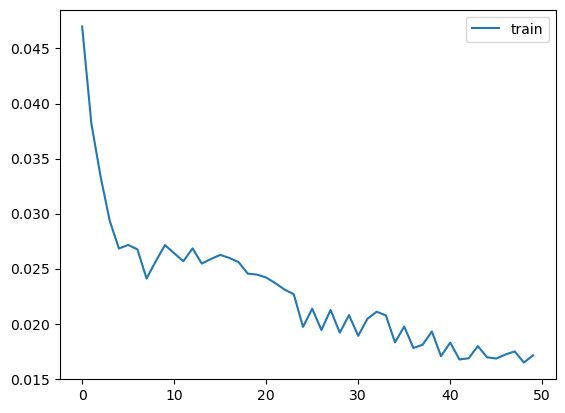

In [7]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

```
# make a prediction
# vec_X_test = vec_X_test.reshape((vec_X_test.shape[0], vec_X_test.shape[2]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, vec_X_test[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# vec_y_test = vec_y_test.reshape((len(vec_y_test), 1))
# inv_y = np.concatenate((vec_y_test, vec_X_test[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
```

In [8]:
yhat = model.predict(vec_X_test)

mabs_error = mean_absolute_error(vec_y_test, yhat)
rmse = np.sqrt(mean_squared_error(vec_y_test, yhat))

print('Mean Absolute Error: %.3f' % mabs_error)
print('RMSE: %.3f' % rmse)

114/114 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.024
RMSE: 0.033


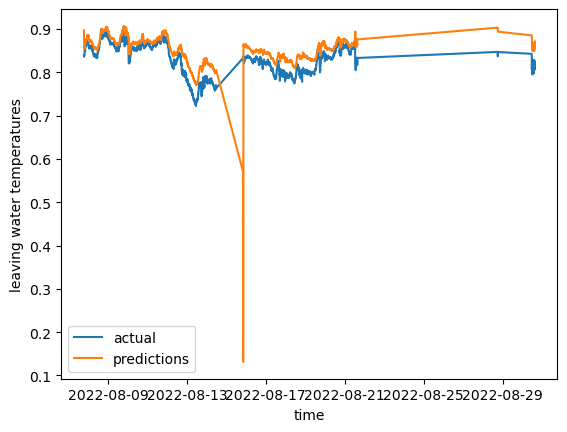

In [13]:
# Plot the lines using Matplotlib
plt.plot(y_test.index, vec_y_test, label='actual', color='C0')
plt.plot(y_test.index, yhat, label='predictions', color='C1')

# Add labels and legend
plt.xlabel('time')
plt.ylabel('leaving water temperatures')
plt.legend()

In [10]:
model.summary()
model.save('../models_saved/esb1_summer_lstm/')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ../models_saved/esb1_summer_lstm/assets


INFO:tensorflow:Assets written to: ../models_saved/esb1_summer_lstm/assets
